In [15]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from datetime import datetime
import sqlalchemy
from sqlalchemy import create_engine
import pymysql

In [3]:
#Load dataset 2020 Feb
df = pd.read_csv("Cleaned_Feb_2020.csv",low_memory=False , index_col=0)
df.head(2)

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
0,1,6,MQ,ORD,TUL,1646.0,0.0,1600-1659,1820.0,0.0,585.0
1,1,6,MQ,JFK,BNA,1336.0,0.0,1300-1359,1458.0,0.0,765.0


In [4]:
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (568076, 11)


,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
column type,int64,int64,object,object,object,float64,float64,object,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0


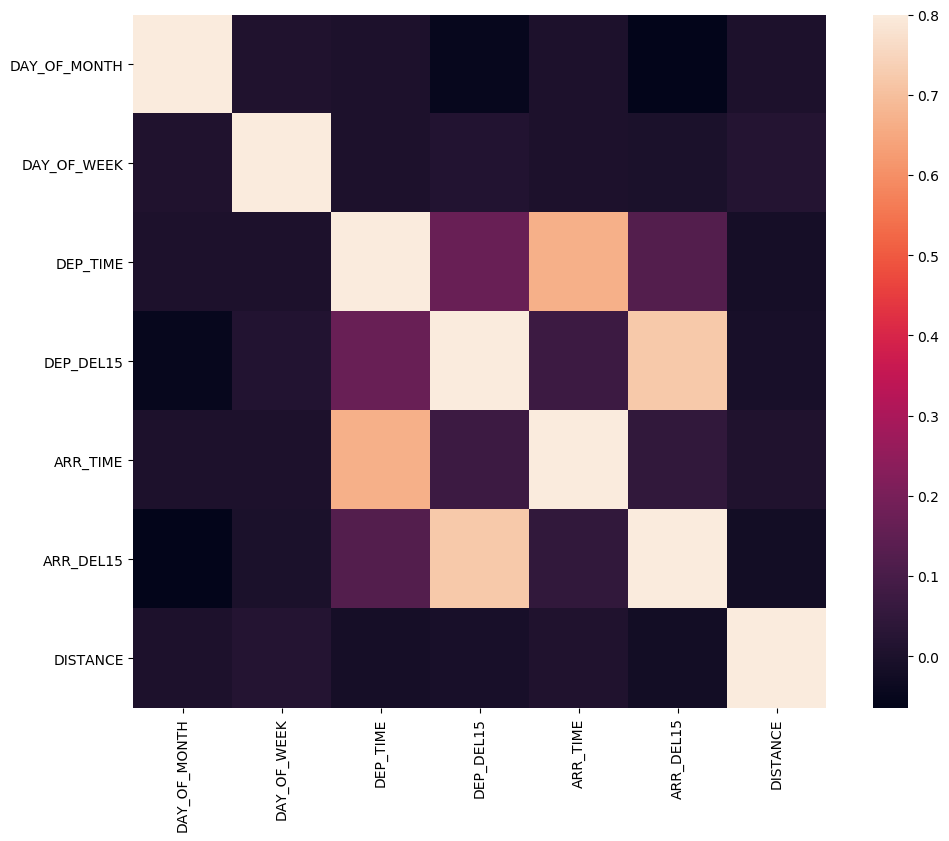

In [32]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

<h1> 1. Total Number of Airports in this dataset.

In [19]:
print("Number of airports: {}".format(len(df['ORIGIN'].unique())))

Number of airports: 350


<h1>2. Comparing airlines

In [20]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,F9,Frontier Airlines Inc.
3,B6,JetBlue Airways
4,OO,Skywest Airlines Inc.
5,AS,Alaska Airlines Inc.
6,NK,Spirit Air Lines
7,WN,Southwest Airlines Co.
8,DL,Delta Air Lines Inc.
9,EV,Atlantic Southeast Airlines


In [21]:
#Abber... to dictionaries with Airlines code
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [27]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(),'sum': group.sum()}

<h1>Distance coverage 

In [28]:

global_stats = df['DISTANCE'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean,sum
AIRLINE,,,,,
HA,84.0,5095.0,6475.0,804.384093,5208387.0
G4,237.0,1900.0,8666.0,911.343065,7897699.0
EV,74.0,1416.0,11307.0,488.725480,5526019.0
F9,226.0,2227.0,11437.0,1033.514121,11820301.0
YV,94.0,1530.0,16550.0,611.985982,10128368.0
NK,177.0,2402.0,17279.0,1010.185427,17454994.0
AS,31.0,2874.0,19301.0,1308.412362,25253667.0
9E,74.0,1391.0,21498.0,440.894641,9478353.0
OH,75.0,1088.0,21757.0,413.644896,8999672.0


In [24]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

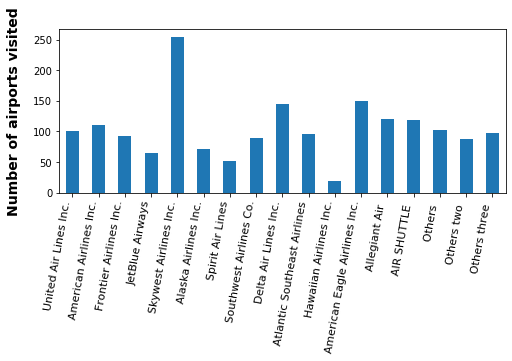

In [25]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)

plt.show()

<h1> Delay

In [30]:

global_stats = df['DEP_DEL15'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean,sum
AIRLINE,,,,,
HA,0.0,1.0,6475.0,0.060232,390.0
G4,0.0,1.0,8666.0,0.199862,1732.0
EV,0.0,1.0,11307.0,0.114265,1292.0
F9,0.0,1.0,11437.0,0.182041,2082.0
YV,0.0,1.0,16550.0,0.140725,2329.0
NK,0.0,1.0,17279.0,0.167255,2890.0
AS,0.0,1.0,19301.0,0.133724,2581.0
9E,0.0,1.0,21498.0,0.153456,3299.0
OH,0.0,1.0,21757.0,0.263639,5736.0


Text(0.5, 0, 'Mean delay [min] (@departure: blue, @arrival: hatch lines)')

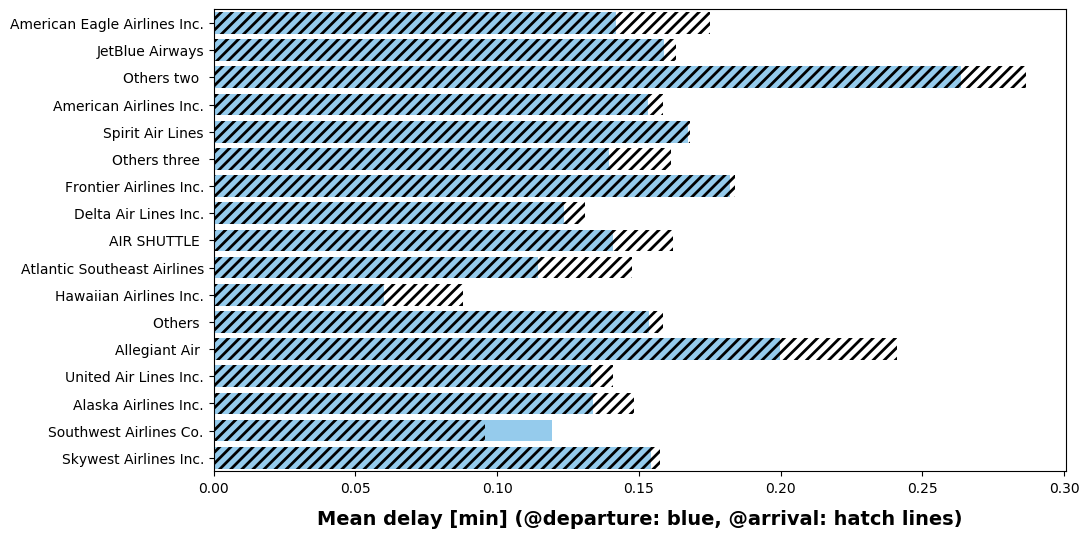

In [50]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEP_DEL15", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARR_DEL15", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10)

In [43]:
airports = pd.read_csv("airport.csv")
airports.head(2)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819


In [44]:
count_flights = df['ORIGIN'].value_counts()

In [46]:
identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [47]:
def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(7,3))
    ax=fig.add_axes([0.,0.,1.,1.])
    m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,
                  llcrnrlat=lat_min, urcrnrlat=lat_max, lat_0=0, lon_0=0,)
    df2 = df[df['AIRLINE'] == carrier]
    count_trajectories = df2.groupby(['ORIGIN', 'DEST']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
                   color = 'seagreen', markeredgecolor='k')

    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or \
                pd.isnull(lonlat) or pd.isnull(lonlon): continue
        if s < 100:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
        elif s < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
    #_____________________________________________
    # remove duplicate labels and set their order
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)    
    m.drawcoastlines()
    m.fillcontinents()
    ax.set_title('{} flights'.format(abbr_companies[carrier]))

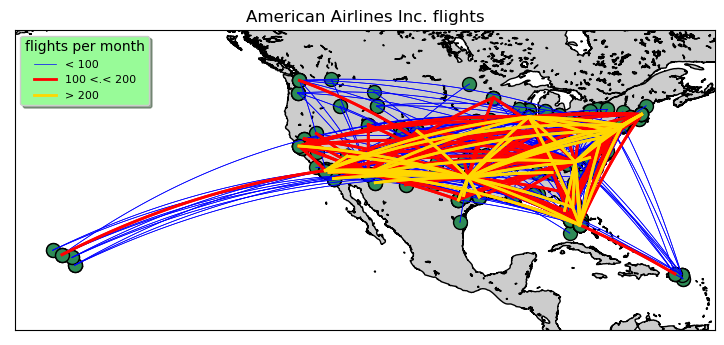

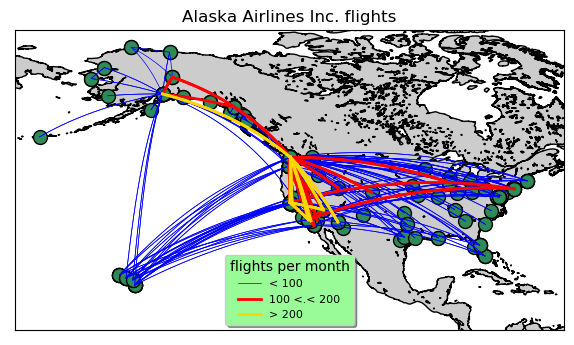

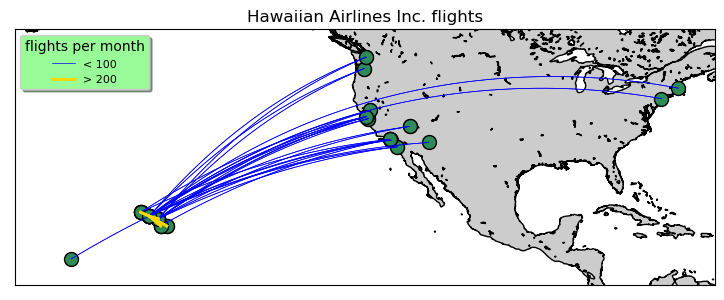

In [48]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA', 'AS', 'HA']: 
    make_map(df, carrier, *coord[carrier])

<h2> Now going to select one Airline and Explore Delay , distance Coverage of that Airline in Month 

<h1> American Airline


In [42]:

data_american =df[(df.AIRLINE=='AA')]
data_american

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
1320,1,6,AA,DFW,MCI,1708.0,0.0,1700-1759,1846.0,0.0,460.0
1321,1,6,AA,PHX,DFW,945.0,0.0,0900-0959,1319.0,0.0,868.0
1322,1,6,AA,MIA,BDL,2041.0,1.0,1900-1959,2329.0,1.0,1194.0
1323,1,6,AA,ABQ,PHX,1138.0,0.0,1100-1159,1253.0,0.0,328.0
1324,1,6,AA,PHX,ABQ,936.0,0.0,0900-0959,1044.0,0.0,328.0
...,...,...,...,...,...,...,...,...,...,...,...
566841,29,6,AA,PHL,BDL,2100.0,0.0,2100-2159,2157.0,0.0,196.0
566842,29,6,AA,MIA,CLT,1742.0,0.0,1700-1759,1958.0,0.0,650.0
566843,29,6,AA,CLT,CLE,751.0,0.0,0700-0759,926.0,0.0,430.0
566844,29,6,AA,ABQ,PHX,1135.0,0.0,1100-1159,1245.0,0.0,328.0


In [10]:
_

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
column type,int64,int64,object,object,object,float64,float64,object,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0


In [20]:
#American Airline total flight in one month is 71577 flight 
# we are going to see days of week data in week 
data_american_mon =data_american[(data_american.DAY_OF_WEEK ==1) & (data_american.DAY_OF_MONTH <=7)]
data_american_mon


,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
35959,3,1,AA,LAX,MIA,1634.0,1.0,1200-1259,18.0,1.0,2342.0
35960,3,1,AA,DFW,MCI,1901.0,0.0,1900-1959,2038.0,0.0,460.0
35961,3,1,AA,PHX,DFW,944.0,0.0,0900-0959,1300.0,0.0,868.0
35962,3,1,AA,MIA,BDL,1950.0,0.0,1900-1959,2248.0,0.0,1194.0
35963,3,1,AA,ABQ,PHX,1148.0,0.0,1100-1159,1300.0,0.0,328.0
...,...,...,...,...,...,...,...,...,...,...,...
49755,3,1,AA,CLT,PIT,1313.0,0.0,1300-1359,1430.0,0.0,366.0
49756,3,1,AA,PIT,CLT,1534.0,0.0,1500-1559,1700.0,0.0,366.0
49757,3,1,AA,CLT,SAT,726.0,0.0,0700-0759,918.0,0.0,1095.0
49758,3,1,AA,SAT,CLT,1025.0,0.0,1000-1059,1404.0,0.0,1095.0


In [66]:
#Origin and Distination first to see the flight origin and distination 
data_american_mon.DEST.unique()

array(['MIA', 'MCI', 'DFW', 'BDL', 'PHX', 'ABQ', 'LAX', 'BOS', 'CLT',
       'JFK', 'SAT', 'FAT', 'RDU', 'LGA', 'ATL', 'PWM', 'LAS', 'IAD',
       'STX', 'ORD', 'JAX', 'DCA', 'PDX', 'AUS', 'PHL', 'MCO', 'SJU',
       'TPA', 'EWR', 'DSM', 'STL', 'EYW', 'TUL', 'SLC', 'DEN', 'STT',
       'MSP', 'BWI', 'ELP', 'PBI', 'IAH', 'BNA', 'OKC', 'SFO', 'SMF',
       'RIC', 'FLL', 'COS', 'MSY', 'OMA', 'PNS', 'MTJ', 'SEA', 'SNA',
       'GSP', 'RNO', 'EGE', 'ONT', 'RSW', 'TUS', 'MEM', 'DTW', 'SAN',
       'OAK', 'OGG', 'GEG', 'ORF', 'JAC', 'BUR', 'CVG', 'XNA', 'IND',
       'SDF', 'BUF', 'PSP', 'SJC', 'BZN', 'MAF', 'MFE', 'LBB', 'PIT',
       'ICT', 'SBA', 'DAB', 'GSO', 'SYR', 'LIH', 'CLE', 'HNL', 'GRR',
       'FAR', 'SRQ', 'MSN', 'PVD', 'BOI', 'ILM', 'VPS', 'KOA', 'MYR',
       'SAV', 'MKE', 'CMH', 'CHS', 'BHM', 'AMA', 'MDT', 'GUC', 'HDN',
       'ROC', 'MLB', 'ALB'], dtype=object)

In [76]:
data_american_mon.ORIGIN.unique()

array(['LAX', 'DFW', 'PHX', 'MIA', 'ABQ', 'DCA', 'ORD', 'JFK', 'LGA',
       'RSW', 'SAT', 'BOS', 'ATL', 'PHL', 'CLT', 'STX', 'IND', 'SJU',
       'PBI', 'PDX', 'COS', 'AUS', 'EWR', 'BDL', 'CHS', 'TUS', 'IAH',
       'TPA', 'LAS', 'RNO', 'MCO', 'SAN', 'STL', 'EYW', 'TUL', 'SJC',
       'SLC', 'MSP', 'BWI', 'DEN', 'ELP', 'SNA', 'OKC', 'ORF', 'MCI',
       'SMF', 'RIC', 'DSM', 'OMA', 'BNA', 'JAC', 'FLL', 'MTJ', 'RDU',
       'PSP', 'SAV', 'EGE', 'SEA', 'MAF', 'DTW', 'MEM', 'JAX', 'STT',
       'MSY', 'SFO', 'ONT', 'PVD', 'IAD', 'BUR', 'CVG', 'MKE', 'SDF',
       'MFE', 'FAT', 'BUF', 'LBB', 'PIT', 'ICT', 'SBA', 'MDT', 'GEG',
       'BHM', 'DAB', 'GSO', 'SYR', 'HNL', 'OAK', 'LIH', 'GRR', 'PWM',
       'FAR', 'SRQ', 'MSN', 'CMH', 'CLE', 'VPS', 'XNA', 'OGG', 'KOA',
       'BZN', 'ALB', 'BOI', 'MYR', 'GSP', 'PNS', 'ILM', 'GUC', 'HDN',
       'ROC', 'MLB', 'AMA'], dtype=object)

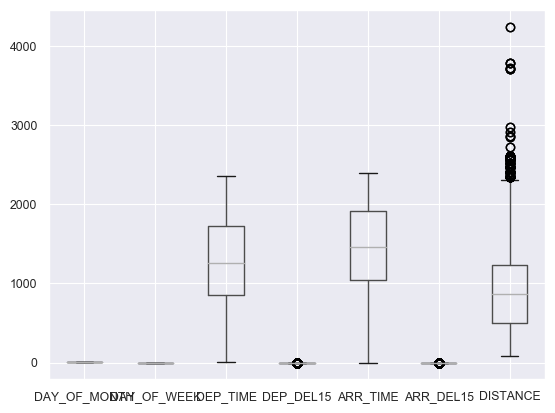

In [70]:
data_american_mon.boxplot()

In [82]:
#NOW LOOK THE DETAIL 
data_american_Mi =data_american_mon[(data_american_mon.ORIGIN =='MIA') ]
data_american_Mi

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
35962,3,1,AA,MIA,BDL,1950.0,0.0,1900-1959,2248.0,0.0,1194.0
35976,3,1,AA,MIA,RDU,2139.0,0.0,2100-2159,2347.0,0.0,700.0
35984,3,1,AA,MIA,STX,1215.0,0.0,1200-1259,1557.0,0.0,1139.0
35992,3,1,AA,MIA,ATL,1259.0,0.0,1300-1359,1446.0,0.0,594.0
36015,3,1,AA,MIA,AUS,1411.0,0.0,1400-1459,1601.0,0.0,1103.0
...,...,...,...,...,...,...,...,...,...,...,...
49540,3,1,AA,MIA,CLT,2132.0,0.0,2100-2159,2339.0,0.0,650.0
49609,3,1,AA,MIA,DCA,1431.0,1.0,1400-1459,1656.0,0.0,919.0
49618,3,1,AA,MIA,LAS,1941.0,0.0,1900-1959,2145.0,0.0,2174.0
49708,3,1,AA,MIA,DFW,101.0,1.0,1900-1959,257.0,1.0,1121.0


In [85]:
data_american_Mci =data_american_mon[(data_american_mon.ORIGIN =='MCI') ]
data_american_Mci

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
36134,3,1,AA,MCI,CLT,456.0,0.0,0001-0559,817.0,0.0,808.0
36420,3,1,AA,MCI,PHX,1812.0,0.0,1800-1859,2034.0,1.0,1044.0
40155,3,1,AA,MCI,MIA,514.0,0.0,0001-0559,908.0,0.0,1251.0
40159,3,1,AA,MCI,MIA,1407.0,0.0,1400-1459,1814.0,0.0,1251.0
40163,3,1,AA,MCI,DFW,931.0,0.0,0900-0959,1111.0,0.0,460.0
40167,3,1,AA,MCI,MIA,1206.0,1.0,1100-1159,1548.0,1.0,1251.0
40169,3,1,AA,MCI,MIA,1931.0,0.0,1900-1959,2321.0,0.0,1251.0
43544,3,1,AA,MCI,DFW,1106.0,0.0,1100-1159,1248.0,0.0,460.0
43720,3,1,AA,MCI,ORD,649.0,0.0,0600-0659,808.0,0.0,403.0
43751,3,1,AA,MCI,DFW,1219.0,1.0,0600-0659,1405.0,1.0,460.0


In [23]:
data_american_Tues =data_american[(data_american.DAY_OF_WEEK ==2) & (data_american.DAY_OF_MONTH <=7)]
data_american_Tues

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
56473,4,2,AA,MIA,PHX,2144.0,0.0,2100-2159,34.0,0.0,1972.0
56474,4,2,AA,MSY,PHL,1533.0,0.0,1500-1559,1903.0,0.0,1089.0
56475,4,2,AA,PHL,MSY,1236.0,0.0,1200-1259,1454.0,0.0,1089.0
56476,4,2,AA,PHL,DTW,2122.0,0.0,2100-2159,2301.0,0.0,453.0
56477,4,2,AA,PHX,PHL,1309.0,0.0,1300-1359,1906.0,0.0,2075.0
...,...,...,...,...,...,...,...,...,...,...,...
70770,4,2,AA,BOS,CLT,738.0,0.0,0700-0759,1001.0,0.0,728.0
70771,4,2,AA,CLT,PHL,1520.0,0.0,1500-1559,1653.0,0.0,449.0
70772,4,2,AA,LGA,CLT,917.0,0.0,0900-0959,1114.0,0.0,544.0
70773,4,2,AA,CLT,MCI,922.0,0.0,0900-0959,1050.0,0.0,808.0


In [25]:
data_american_wed =data_american[(data_american.DAY_OF_WEEK ==3) & (data_american.DAY_OF_MONTH <=7)]
data_american_wed

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
75334,5,3,AA,LAX,MIA,1214.0,0.0,1200-1259,2002.0,0.0,2342.0
75335,5,3,AA,PHX,DFW,1039.0,1.0,0900-0959,1359.0,1.0,868.0
75336,5,3,AA,IAH,DFW,2034.0,0.0,2000-2059,2155.0,0.0,224.0
75337,5,3,AA,MIA,BDL,1953.0,0.0,1900-1959,2252.0,0.0,1194.0
75338,5,3,AA,ABQ,PHX,1137.0,0.0,1100-1159,1254.0,0.0,328.0
...,...,...,...,...,...,...,...,...,...,...,...
91101,5,3,AA,CLT,PIT,1314.0,0.0,1300-1359,1433.0,0.0,366.0
91102,5,3,AA,PIT,CLT,1811.0,1.0,1500-1559,2000.0,1.0,366.0
91103,5,3,AA,CLT,SAT,724.0,0.0,0700-0759,931.0,0.0,1095.0
91104,5,3,AA,SAT,CLT,1023.0,0.0,1000-1059,1355.0,0.0,1095.0


In [27]:
data_american_Thu =data_american[(data_american.DAY_OF_WEEK ==4) & (data_american.DAY_OF_MONTH <=7)]
data_american_Thu

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
95567,6,4,AA,MIA,PHX,2145.0,0.0,2100-2159,206.0,1.0,1972.0
95568,6,4,AA,MSY,PHL,1642.0,1.0,1500-1559,2013.0,1.0,1089.0
95569,6,4,AA,PHL,MSY,1244.0,0.0,1200-1259,1531.0,1.0,1089.0
95570,6,4,AA,PHL,DTW,2133.0,0.0,2100-2159,2314.0,0.0,453.0
95571,6,4,AA,PHX,PHL,1310.0,0.0,1300-1359,1930.0,0.0,2075.0
...,...,...,...,...,...,...,...,...,...,...,...
112645,6,4,AA,SEA,PHX,825.0,1.0,0700-0759,1203.0,0.0,1107.0
112646,6,4,AA,PHX,PDX,1814.0,0.0,1800-1859,1955.0,0.0,1009.0
112647,6,4,AA,LAX,SFO,820.0,0.0,0800-0859,937.0,0.0,337.0
112648,6,4,AA,ICT,DFW,555.0,0.0,0600-0659,736.0,0.0,328.0


In [29]:
data_american_fri =data_american[(data_american.DAY_OF_WEEK ==5) & (data_american.DAY_OF_MONTH <=7)]
data_american_fri

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
116010,7,5,AA,LAX,MIA,1342.0,1.0,1200-1259,2112.0,1.0,2342.0
116011,7,5,AA,ORD,MIA,1016.0,0.0,1000-1059,1415.0,0.0,1197.0
116012,7,5,AA,PHX,DFW,942.0,0.0,0900-0959,1259.0,0.0,868.0
116013,7,5,AA,IAH,DFW,2204.0,1.0,2000-2059,2303.0,1.0,224.0
116014,7,5,AA,MIA,BDL,1953.0,0.0,1900-1959,2225.0,0.0,1194.0
...,...,...,...,...,...,...,...,...,...,...,...
135330,7,5,AA,CLT,PIT,1345.0,1.0,1300-1359,1502.0,1.0,366.0
135331,7,5,AA,PIT,CLT,1723.0,1.0,1500-1559,1902.0,1.0,366.0
135332,7,5,AA,CLT,SAT,736.0,0.0,0700-0759,944.0,0.0,1095.0
135333,7,5,AA,SAT,CLT,1028.0,0.0,1000-1059,1356.0,0.0,1095.0


In [32]:
data_american_sat=data_american[(data_american.DAY_OF_WEEK ==6) & (data_american.DAY_OF_MONTH <=7)]
data_american_sat

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
1320,1,6,AA,DFW,MCI,1708.0,0.0,1700-1759,1846.0,0.0,460.0
1321,1,6,AA,PHX,DFW,945.0,0.0,0900-0959,1319.0,0.0,868.0
1322,1,6,AA,MIA,BDL,2041.0,1.0,1900-1959,2329.0,1.0,1194.0
1323,1,6,AA,ABQ,PHX,1138.0,0.0,1100-1159,1253.0,0.0,328.0
1324,1,6,AA,PHX,ABQ,936.0,0.0,0900-0959,1044.0,0.0,328.0
...,...,...,...,...,...,...,...,...,...,...,...
10295,1,6,AA,CLT,PIT,1309.0,0.0,1300-1359,1417.0,0.0,366.0
10296,1,6,AA,PIT,CLT,1515.0,0.0,1500-1559,1652.0,0.0,366.0
10297,1,6,AA,CLT,SAT,752.0,0.0,0800-0859,1009.0,0.0,1095.0
10298,1,6,AA,SAT,CLT,1108.0,0.0,1100-1159,1435.0,0.0,1095.0


In [35]:
data_american_sun=data_american[(data_american.DAY_OF_WEEK ==7) & (data_american.DAY_OF_MONTH <=7)]
data_american_sun

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
16233,2,7,AA,MIA,PHX,2129.0,0.0,2100-2159,11.0,0.0,1972.0
16234,2,7,AA,MSY,PHL,1537.0,0.0,1500-1559,1924.0,0.0,1089.0
16235,2,7,AA,PHL,MSY,1303.0,1.0,1200-1259,1449.0,0.0,1089.0
16236,2,7,AA,PHL,DTW,2116.0,0.0,2100-2159,2303.0,0.0,453.0
16237,2,7,AA,PHX,PHL,1316.0,0.0,1300-1359,1947.0,0.0,2075.0
...,...,...,...,...,...,...,...,...,...,...,...
31574,2,7,AA,SEA,PHX,754.0,0.0,0700-0759,1202.0,0.0,1107.0
31575,2,7,AA,PHX,PDX,1817.0,0.0,1800-1859,1957.0,0.0,1009.0
31576,2,7,AA,LAX,SFO,814.0,0.0,0800-0859,952.0,0.0,337.0
31577,2,7,AA,ICT,DFW,557.0,0.0,0600-0659,719.0,0.0,328.0


In [43]:
#EXport weekly flight to database SQl 
driver = 'mysql+pymysql:'
user = 'root'
password = 'Mingii1212@@'
ip = '127.0.0.1'
database = 'feb_2020'
connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string, pool_size=10, max_overflow=20)


In [45]:
#data_american.to_sql("american_airline",engine)

In [24]:
#data_american_Tues.to_sql("tuesday_flight",engine)

In [26]:
#data_american_wed.to_sql("wedn_flight",engine)

In [28]:
#data_american_Thu.to_sql("thursday_flight",engine)

In [30]:
#data_american_fri.to_sql("friday_flight",engine)

In [33]:
#data_american_sat.to_sql("saturday_flight",engine)

In [37]:
#data_american_sun.to_sql("sun_flight",engine)